# Contagion on networks

We want to look at how something might spread on networks, i.e., a vague *contagion*. This could be something bad like misinformation among social media users or an infectious disease on a contact network. Or something good like innovations in science. We assume that the thing can spread from one affected node (infectious individual) of the network to any of its neighbors (contacts) independently. The independence is important for now, and means this is a simple [cascade model](https://en.wikipedia.org/wiki/Global_cascades_model)

Let us assume that the contagion starts on some random patient zero. The network has a certain degree distribution $p_k$; i.e., a distribution for the number of contacts of every node. We can then say that the degree of our patient zero is generated by

$$
G_0(x) = \sum_{k=0}^\infty p_k x^k
$$

The contagion starts on that node but it can only spread to its $k$ neighbors with some probability $T$, call $T$ a transmission probability. What happens then?

Well, for a single edge (contact or relationship) in the network, the probability generating function of the number of spreading events it causes is as follows

$$
(1-T)+Tx
$$

since it spreads to its single destination with probability $T$ and does nothing with probability $1-T$. So we are really asking patient zero: How many transmissions will you cause out of your $k$ edges? This is the sum of $k$ random variables (which are 0 or 1) and each of them is generated by the transmission PGF above! We know this sum of a random number of random variable is generated by a construction. In this case

$$
G_0(1-T+Tx)
$$

Building on the previous application, we can assume that the contagion sees the network as a [branching process](https://en.wikipedia.org/wiki/Branching_process) speading from neighbor to neighbor. But there is a twist! The neighbors of our patient zero do not have a degree distribution generated from $G_0(x)$. Why do we know what? For one thing, they cannot have a degree zero since they are neighbors of patient zero. In fact, by following an edge from patient zero, we are following a random edge and therefore $k$ times more likely to reach a node of degree $k$ than a node of degree 1. After all, nodes of high degrees (so-called hubs of the network) are more likely to be neighbors of patient zero than low degree nodes since they have more neighbors. We therefore have to bias the degree distribution to take this network effect into account. The number other neighbors of a random neighbor (meaning, its degree excluding the edge we arrived from) is called the *excess degree* of a node and is generated by

$$
G_1(x) \propto \sum_{k=0}^\infty kp_kx^{k-1} = \frac{d}{dx}G_0(x) \equiv G_0'(x)
$$

We use a proportional relationship because the derivative of $G_0(x)$ at $x=1$ might not be normalized, which is a key properties of PGFs. We therefore have to do that by hand, resulting in

$$
G_1(x) = \frac{G_0'(x)}{G_0'(1)}
$$

where the normalization is really the average degree of the network. This means that while the degree of a random node is drawn proportionally to $p_k$, the degree $k$ of a neighbor is drawn proportionally to $kp_k$ and therefore biased towards higher values. This is called the [Friendship Paradox](https://en.wikipedia.org/wiki/Friendship_paradox) and is why your friends have more friends than you do! Here it means that cases caused by patient zero are likely to cause more cases than patient zero. In fact, we now know that the number of transmissions caused by a random neighbor of patient zero will be generated by

$$
G_1(1-T+Tx)
$$

## Supercritical contagions

Using the above, we can now use our previous results! What is the probability of extinction $u$ downstream from a transmission event? It is the probability that all edges, if any, of the node infected also lead to extinction. This implies the following self-consistent condition:

$$
u=G_1(1-T+Tu)
$$

:::{note}
One important note is that we are here assuming that the other neighbors of the node we reach are independent from one another. E.g., if that node has an excess degree of 2, both of them lead to extinction with probability $(1-T+Tu)^2$. And that is only true if the network is a tree, or sufficiently locally treelike!
:::

Using the same logic around patient zero, the probability of extinction requires extinction through all transmissions caused by patient zero. Inversely, the probability that the outbreak *never* stops is

$$
1 - G_0(1-T+Tu)
$$

Here is a simple example using a network where $10\%$ of nodes have degree 1, $20\%$ have degree 2, $30\%$ have degree 3, and $40\%$ have degree 4.

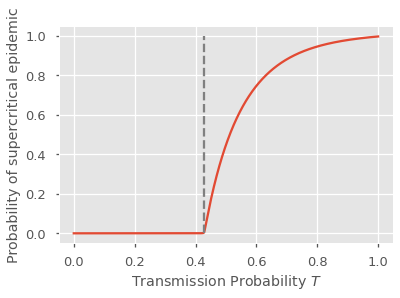

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot', 'seaborn-talk'])

pk = np.array([[1,0.1],[2,0.2],[3,0.3],[4,0.4]])

def G0(x, pk, T):
    x = (1-T) + T*x
    return np.power(x[np.newaxis].T, pk[:, 0]).dot(pk[:, 1])

def G1(x, pk, T):
    x = (1-T) + T*x
    return np.power(x[np.newaxis].T, pk[:, 0] - 1).dot(
        np.multiply(pk[:, 1], pk[:, 0])) / pk[:, 0].dot(pk[:, 1])

Tlist = np.linspace(0.0,1.0,1000)
usol = []
Pext = []
for T in reversed(Tlist):
    u1 = usol[-1].copy() if usol else 0.5
    u2 = G1(u1,pk,T)
    while  abs(u2-u1) > 10**(-5):
        u1 = u2.copy()
        u2 = G1(u1,pk,T)
    usol.append(u2)
    Pext.append(1-G0(u2,pk,T))
Pext = list(reversed(Pext))
plt.plot(Tlist,Pext)
plt.vlines(30/70,0,1,ls='--',color='grey') #critical transmissibility
plt.xlabel(r"Transmission Probability $T$")
plt.ylabel(r"Epidemic size")
plt.show()

You can see a clear transition, or an epidemic threshold, where the probability of extinction starts falling below $100\%$. This is when the [Basic Reproduction Number](https://en.wikipedia.org/wiki/Basic_reproduction_number) rises above 1. In terms of our PGF, this number $R_0$ can be calculated as

$$
R_0 = \frac{d}{dx}G_1(1-T+Tx)\bigg\vert_{x=1}
$$

where again we use the fact that the average of the distribution generated by a PGF is simply its derivative evaluated at 1.

:::{note}
Because we assumed an undirected networks, where the contagion can spread in both directions on an edge, then the probability of a supercritical epidemic is the same as the relative size of this epidemic in the network. How can that be? The process used to model the spread is called [bond percolation](https://en.wikipedia.org/wiki/Percolation_theory) where every edge exists with fixed probability. What we calculated is the probability that the epidemic does not stop, but it is equivalent to asking about the probability of picking a node that is part of an infinite component in the percolated network (called a *giant component*). That probability is equal to the size of that infinite component relative to the size of the infinite network! Epidemic probability equals epidemic size (on undirected networks).
:::

## Sizes of subcritical outbreaks

Instead of asking about the probability of an outbreak going extinct from a transmission event, let's adjust our self-consistent condition to ask about the distribution of sizes for outbreaks that go extinct. Let's say that this unknown distribution of sizes downstream from an edge is generated by $H_1(x)$. Then $H_1(x)$ must be equal to at least one node, the node reached, plus the PGFs of the cumulative sizes of the outbreaks downstream from the excess transmissions of the node reached. This implies the following new self-consistent condition:

$$
H_1(x) = xG_1(1-T+TH_1(x))
$$

where the $x$ factors accounts for the node reached, $G_1(1-T+Tx)$ for its excess transmissions, and $H_1(x)$ for the components downstream from those transmissions. And knowing $H_1(x)$ we can calculate the distribution of the size of subcritical outbreaks around patient zero like so

$$
H_0(x) = xG_0(1-T+TH_1(x))
$$

:::{note}
These are also using treelike assumptions! But notice that we only assume a tree structure in small subcritical outbreaks. We are not saying anything about the structure of the network within the supercritical epidemic! Clever.
:::

We are definitely now calculating probabilities that would be hard to calculate without PGFs!

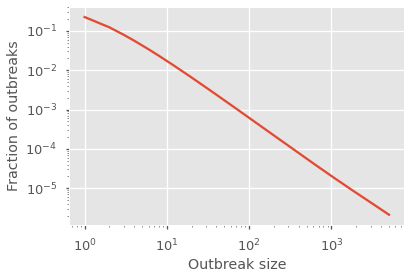

In [2]:
# Computes the distribution of the size of subcritical outbreaks.
def get_outbreak_size_dist(x, pk, T):
    new_H1 = np.zeros(len(x))
    old_H1 = np.ones(len(x))
    # Solve for H1 by iterating yet again
    while(not np.allclose(old_H1, new_H1, rtol=1e-08, atol=1e-10)):
        old_H1 = np.copy(new_H1)
        new_H1 = np.multiply(x, G1(old_H1, pk, T))
    # Computes H0 evaluated at x
    H0_at_z = np.multiply(x, G0(new_H1, pk, T))
    # Returns the distribution of the size of small components with the ifft trick
    return np.absolute(np.fft.ifft(H0_at_z))[::-1]

T = 0.425

# Sample of the unit circle.
N = 5000  # (needs to be large enough to minimize the effect of aliasing)
z = np.exp(2 * np.pi * complex(0, 1) * np.arange(N) / N)

# Solves the small component size distribution.
CompDist = get_outbreak_size_dist(z, pk, T)

Norm = np.sum(CompDist)

plt.plot(np.arange(1,len(CompDist)+1),CompDist/Norm)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Outbreak size")
plt.ylabel(r"Fraction of outbreaks")

plt.show()

How different is the distribution of outbreak sizes before, around and after the epidemic threshold? Play around with the transmission probability $T$ in the code snippet above to find out!

:::{note}
Notice that we manually renormalize the calculation of $H_0(x)$ in order to plot the normalized distribution of subcritical outbreaks. Why? Because $H_0(x)$ is not actually normalized. There is a missing probability... The probability that the outbreak never goes extinct! That's right! $H_0(1)$ is equal to the probability of extinction! The missing probability mass corresponds to supercritical outbreaks and essentially went towards $x^\infty$, a term we never get to see. You can therefore use the norm of $H_0(x)$ to evaluate where you are on the previous figure plotting the probability of extinction.
:::

In [3]:
print('Probability of extinction = ', Norm)

Probability of extinction =  0.9999984684581261
